In [2]:
import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from tensorflow import keras as K
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.utils.vis_utils import plot_model
import gc
from keras.layers import Input, Conv2D, BatchNormalization, Activation, UpSampling2D, Conv2DTranspose, Reshape, Dropout, concatenate, Concatenate, multiply, add, MaxPooling2D, Lambda, Activation, subtract, Flatten, Dense
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [3]:
df = pd.read_csv('../input/azure-data/AzureReadings_at_a_timestamp.csv')
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()

,min cpu,max cpu,avg cpu
timestamp,,,
2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06


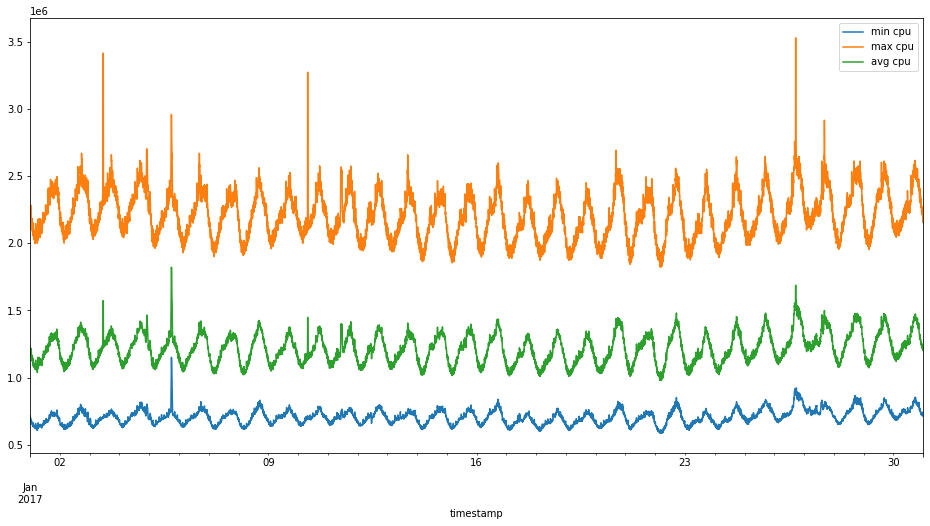

In [4]:
df.plot(figsize=(16, 8))
plt.show()

In [5]:
TRAIN_LENGTH = round(len(df)*0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH : ]

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)

In [7]:
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset)- n_lags -1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [9]:
TIME_STEPS = 350
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(256,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(tf.keras.layers.LSTM(128,return_sequences=False))

model.add(tf.keras.layers.Dense(3))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 350, 256)          266240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 463,747
Trainable params: 463,747
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss='mean_absolute_error', optimizer='adam')

In [13]:
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)






In [15]:
def scheduler(epoch , lr):
    if(epoch==1):
        return 0.00001
    
    
    
    else:
        return lr

lr_sch = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [es , lr_red,lr_sch]

In [19]:
history = model.fit(X_train, y_train, epochs=200, validation_split=0.25, batch_size=
                    16, verbose=1, shuffle=False, callbacks = callbacks)

Epoch 1/200
39/39 [==============================] - 3s 77ms/step - loss: 0.0146 - val_loss: 0.0152 - lr: 1.6000e-07
Epoch 2/200
39/39 [==============================] - 3s 77ms/step - loss: 0.0146 - val_loss: 0.0155 - lr: 1.0000e-04
Epoch 3/200
39/39 [==============================] - 3s 76ms/step - loss: 0.0148 - val_loss: 0.0155 - lr: 1.0000e-04
Epoch 4/200
39/39 [==============================] - 3s 76ms/step - loss: 0.0146 - val_loss: 0.0155 - lr: 1.0000e-04
Epoch 5/200
39/39 [==============================] - ETA: 0s - loss: 0.0145
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
39/39 [==============================] - 3s 76ms/step - loss: 0.0145 - val_loss: 0.0154 - lr: 2.0000e-05
Epoch 6/200
39/39 [==============================] - 3s 76ms/step - loss: 0.0143 - val_loss: 0.0151 - lr: 2.0000e-05
Epoch 7/200
39/39 [==============================] - 3s 76ms/step - loss: 0.0143 - val_loss: 0.0151 - lr: 2.0000e-05
Epoch 8/200
39/39 [=================

Epoch 57/200
39/39 [==============================] - 3s 78ms/step - loss: 0.0140 - val_loss: 0.0151 - lr: 1.0000e-07
Epoch 58/200
39/39 [==============================] - 3s 76ms/step - loss: 0.0140 - val_loss: 0.0151 - lr: 1.0000e-07
Epoch 59/200
39/39 [==============================] - 3s 76ms/step - loss: 0.0140 - val_loss: 0.0151 - lr: 1.0000e-07
Epoch 60/200
39/39 [==============================] - ETA: 0s - loss: 0.0140
Epoch 00060: ReduceLROnPlateau reducing learning rate to 1e-07.
39/39 [==============================] - 3s 77ms/step - loss: 0.0140 - val_loss: 0.0151 - lr: 1.0000e-07
Epoch 61/200
39/39 [==============================] - 3s 76ms/step - loss: 0.0140 - val_loss: 0.0151 - lr: 1.0000e-07
Epoch 62/200
39/39 [==============================] - 3s 77ms/step - loss: 0.0140 - val_loss: 0.0151 - lr: 1.0000e-07
Epoch 63/200
39/39 [==============================] - 3s 77ms/step - loss: 0.0140 - val_loss: 0.0151 - lr: 1.0000e-07
Epoch 64/200
39/39 [==========================

KeyboardInterrupt: 

In [ ]:
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)



In [ ]:
plt.rcParams["figure.figsize"] = (32,12)

In [ ]:
TestY= pd.DataFrame(y_test,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(preds,columns=['min_cpu','max_cpu','avg_cpu'])


plot_max = plt.figure(1)
plt.plot(TestY['max_cpu'])
plt.plot(PredY['max_cpu'])
plt.show()

plot_min = plt.figure(2)
plt.plot(TestY['min_cpu'])
plt.plot(PredY['min_cpu'])
plt.show()

plot_avg = plt.figure(3)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error


testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test))
print('Test Score: %f MAPE' % (testScore_3))